In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Univariate Setting

In [23]:
# create datasets
def generate_in_distribution_data(n, mu, sigma, pi_in):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = mu
    mu_0 = -mu_1
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, sigma, pi_out, delta):
    n_1 = int(n*pi_out)
    n_0 = int(n*(1-pi_out))
    mu_1 = mu + delta
    mu_0 = -mu + delta
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

### Simulation Study

In [24]:
def compute_decision_rule(X_in, Y_in, X_out, Y_out, alpha):

    X_in_0 = X_in[Y_in == 0]
    X_in_0_bar = np.mean(X_in_0)

    X_in_1 = X_in[Y_in == 1]
    X_in_1_bar = np.mean(X_in_1)

    X_out_0 = X_out[Y_out == 0]
    X_out_0_bar = np.mean(X_out_0)

    X_out_1 = X_out[Y_out == 1]
    X_out_1_bar = np.mean(X_out_1)

    # estimate threshold
    c = (1-alpha)*(X_in_1_bar + X_in_0_bar)/2 + (alpha)*(X_out_1_bar + X_out_0_bar)/2
    
    return c

def compute_empirical_risk(X, Y, c):
    Y_pred = (X > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    delta = 0.8,
    alpha_range=np.arange(0, 1.2, 0.2),
    m_sizes = np.arange(0, 40, 2),
    reps = 1000
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, sigma, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, sigma, pi_in)
            X_out, Y_out = generate_out_distribution_data(m, mu, sigma, pi_out, delta)
            
            for alpha in alpha_range:
                c = compute_decision_rule(X_in, Y_in, X_out, Y_out, alpha)
                df.at[i, str(alpha)] = 1-compute_empirical_risk(X_test, y_test, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Alpha', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Alpha", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Accuracy")
    ax.set_xlabel(r"$m, n = {}$".format(n))
    # ax.set_xlim([0, 100])
    return df

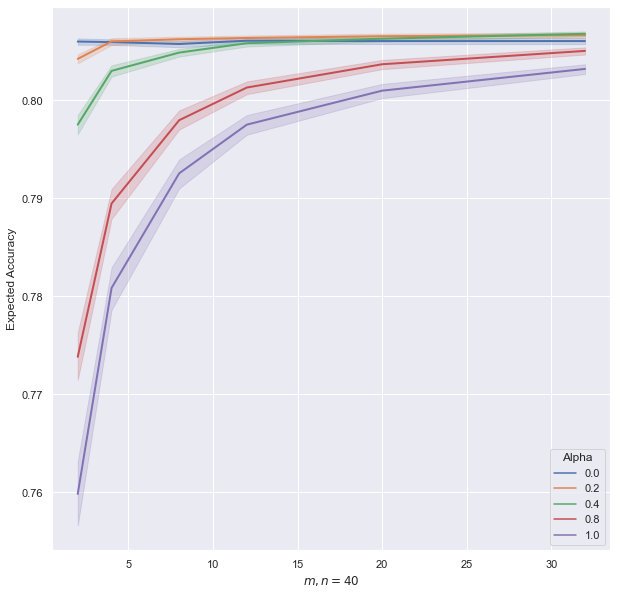

In [26]:
df = run_simulation(
    n = 40,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    delta = 0.1,
    alpha_range=[0.0, 0.2, 0.4, 0.8, 1.0],
    m_sizes = [2, 4, 8, 12, 20, 32],
    reps = 1000
)

### Theoretical Investigation

Let $D_{in} : \{ X_i, Y_i \}_{i=1}^n \stackrel{iid}{\sim} \mathcal{P}_t$ and $D_{out} : \{ X_i, Y_i \}_{i=1}^m \stackrel{iid}{\sim} \mathcal{P}_o$, where $\mathcal{P}_o$ is characterised by $X|Y=y \sim \mathcal{N}(\mu_0 - (-1)^y, 1), \; Y \sim \text{Bern}(0.5)$ and $\mathcal{P}_o$ is characterised by  $X|Y=y \sim \mathcal{N}(\mu_0 + \Delta - (-1)^y, 1), \; Y \sim \text{Bern}(0.5)$. We are interested in the following decision rule:
$$
\begin{equation}
        h(x) = 
        \begin{cases}
            1 & x > \alpha \hat{h}_{out} + (1-\alpha) \hat{h}_{in} \\
            0 & \text{otherwise}
        \end{cases}
\end{equation}
$$
where, 
$$ \hat{h}_{in} = \frac{1}{n} \sum_{i=1}^{n} (X_i + (-1)^{Y_i}) $$
$$ \hat{h}_{out} = \frac{1}{m} \sum_{j=1}^{m} (X_j + (-1)^{Y_j}) $$

It can be shown that the expected value and variance of $\hat{h} = \alpha \hat{h}_{out} + (1-\alpha) \hat{h}_{in}$ is given by (assuming $\mu_0 = 0$),

$$ \mu_h = \mathbb{E}[\hat{h}] = \alpha \Delta $$
$$ \sigma_h^2 = \text{Var}(\hat{h}) = 3 \bigg[ \frac{\alpha^2}{m} + \frac{(1-\alpha)^2}{n} \bigg] $$

The expected target risk is given by,

$$
\begin{equation}
\mathcal{E}_t(h) = \frac{1}{2}\bigg[ 1 + \Phi \bigg( \frac{\mu_h - 1}{\sqrt{1 + \sigma_h^2}} \bigg)  - \Phi \bigg( \frac{\mu_h + 1}{\sqrt{1 + \sigma_h^2}} \bigg)\bigg]
\end{equation}
$$

In [11]:
def expected_risk(n, m, delta, alpha):
    mu_h = alpha*delta
    sigma_h = np.sqrt(3 * (alpha**2/m + (1-alpha)**2/n))
    risk = 0.5*(1 + norm.cdf((mu_h - 1)/(np.sqrt(1 + sigma_h**2))) - norm.cdf((mu_h + 1)/(np.sqrt(1 + sigma_h**2))))
    return risk

Text(0.5, 0, '$m/n, n=40$')

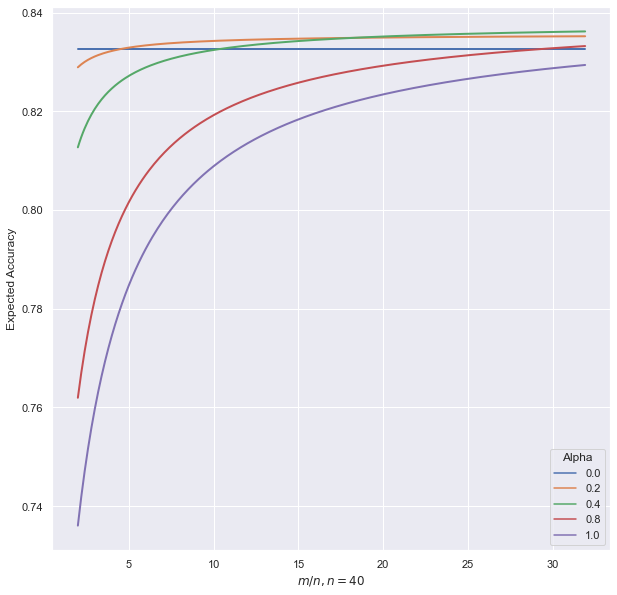

In [15]:
n = 40
m_sizes = np.arange(2, 32, 0.1)
delta = 0.1
alpha_range=[0.0, 0.2, 0.4, 0.8, 1.0]

i = 0
df = pd.DataFrame()
for m in m_sizes:
    df.at[i, "m"] = m
    for alpha in alpha_range:
        df.at[i, str(alpha)] = 1-expected_risk(n, m, delta, alpha)
    i+=1

dfm = df.melt(['m'], var_name='Alpha', value_name='Risk')
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Alpha", ax=ax, markers=True, ci=95, lw=2)
ax.set_ylabel("Expected Accuracy")
ax.set_xlabel(r"$m, n={}$".format(n))
# ax.set_xlim([0, 100])


## Bivariate Setting

Let $D_{in} : \{ X_i, Y_i \}_{i=1}^n \stackrel{iid}{\sim} \mathcal{P}_t$ and $D_{out} : \{ X_i, Y_i \}_{i=1}^m \stackrel{iid}{\sim} \mathcal{P}_o$, where $\mathcal{P}_o$ is characterised by $X|Y=y \sim \mathcal{N}((-1)^{y+1}\mu, I), \; Y \sim \text{Bern}(0.5)$ and $\mathcal{P}_o$ is characterised by  $X|Y=y \sim \mathcal{N}((-1)^{y+1} R_{\theta} \mu, I), \; Y \sim \text{Bern}(0.5)$, where $\mu = [\mu, 0]^\top$ and $R_{\theta}$ is a clockwise rotational matrix. We are interested in the following decision rule:

$$
\begin{equation}
        h(x) = 
        \begin{cases}
            1 & \omega_h^\top x > c_h \\
            0 & \text{otherwise}
        \end{cases}
\end{equation}
$$

where, $\omega_h = \alpha \omega_{o} + (1-\alpha) \omega_{t}$ and $c_h = \alpha c_{o} + (1-\alpha) c_{t}$.

The projection vector $\omega$ and threshold $c$ for a given task (target or OOD) are estimated as follows.

Consider a generic binary LDA. The projection vector is estimated according to the following expression:

$$ \omega = \argmax_{\omega} \frac{(\omega^\top \bar{X}_1 - \omega^\top \bar{X}_0 )^2}{\omega^\top S_w \omega} $$

where, 

$$ S_w = \frac{n_1 S_{1} + n_0 S_{0}}{n} $$

Here, $S_{1}, S_{0}, {X}_{0}, \bar{X}_{1}$ are sample covariance matrices of target class 1 and target class 0, and sample means of target class 0 and class 1 respectively. 

The above maximization problem yields the following expression for the projection vector:

$$ \omega = (S_0 + S_1)^{-1}(\bar{X}_1 - \bar{X}_0) $$

After the projection vector is estimated, the threshold $c$ is estimated by, 

$$ c = \frac{\omega^\top \bar{X}_{0} + \omega^\top \bar{X}_{1}}{2} $$


In [28]:
# create datasets
def generate_in_distribution_data(n, mu, pi_in):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    X_0 = np.random.multivariate_normal(mu_0, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(mu_1, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, pi_out, theta):
    n_1 = int(n*pi_out)
    n_0 = int(n*(1-pi_out))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, s), (-s, c)))
    X_0 = np.random.multivariate_normal(np.matmul(R, mu_0.T).T, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(np.matmul(R, mu_1.T).T, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

### Simulation Study

In [52]:
def bivariate_fld_decision_rule(X, Y):

    X_0 = X[:, Y == 0]
    X_0_bar = np.mean(X_0, axis=-1, keepdims=True)
    X_centered = X_0 - X_0_bar
    S_0 = np.matmul(X_centered, X_centered.T)/len(Y[Y==0])

    X_1 = X[:, Y == 1]
    X_1_bar = np.mean(X_1, axis=-1, keepdims=True)
    X_centered = X_1 - X_1_bar
    S_1 = np.matmul(X_centered, X_centered.T)/len(Y[Y==1])

    # estimate projection vector
    omega = np.matmul(np.linalg.inv(S_0 + S_1), X_1_bar - X_0_bar)

    # estimate threshold
    X_projected = np.matmul(omega.T, X).squeeze()
    c = (np.mean(X_projected[Y == 0]) + np.mean(X_projected[Y == 1]))/2
    
    return omega, c

def combined_decision_rule(X_in, Y_in, X_out, Y_out, alpha):

    omega_in, c_in = bivariate_fld_decision_rule(X_in, Y_in)
    omega_out, c_out = bivariate_fld_decision_rule(X_out, Y_out)

    omega = alpha * omega_out + (1-alpha)*omega_in
    c = alpha * c_out + (1-alpha)*c_in

    return omega, c

def compute_empirical_risk(X, Y, omega, c):
    Y_pred = (np.matmul(omega.T, X) > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def visualize_decision_boundary(n, m, theta, mu=3, pi_in=0.5, pi_out=0.5, alpha=30):
    X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
    X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)

    fig, ax = plt.subplots()
    ax.scatter(X_in[:, Y_in==0][0, :], X_in[:, Y_in==0][1, :], c='b')
    ax.scatter(X_in[:, Y_in==1][0, :], X_in[:, Y_in==1][1, :], c='b')
    ax.scatter(X_out[:, Y_out==0][0, :], X_out[:, Y_out==0][1, :], c='r')
    ax.scatter(X_out[:, Y_out==1][0, :], X_out[:, Y_out==1][1, :], c='r')
    
    x = np.arange(-10, 10, 0.1)

    omega, c = bivariate_fld_decision_rule(X_in, Y_in)
    y = -omega[0]/omega[1]*x + c/omega[1]
    ax.plot(x, y, 'b', label='target')

    omega, c = bivariate_fld_decision_rule(X_out, Y_out)
    y = -omega[0]/omega[1]*x + c/omega[1]
    ax.plot(x, y, 'r', label='OOD')

    omega, c = combined_decision_rule(X_in, Y_in, X_out, Y_out, alpha)
    y = -omega[0]/omega[1]*x + c/omega[1]
    ax.plot(x, y, 'k', label='combined')

    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.legend()

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 3,
    pi_in = 0.5,
    pi_out = 0.5,
    theta = 45,
    alpha_range = [0.0, 0.2, 0.4, 0.8, 1.0],
    m_sizes = np.arange(0, 21, 1),
    reps = 1000,
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
            X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
            
            for alpha in alpha_range:
                omega, c = combined_decision_rule(X_in, Y_in, X_out, Y_out, alpha)
                df.at[i, str(alpha)] = 1-compute_empirical_risk(X_test, y_test, omega, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='alpha', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="alpha", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Accuracy")
    ax.set_xlabel(r"$m, n={}$".format(n))
    # ax.set_xlim([0, 100])
    return df

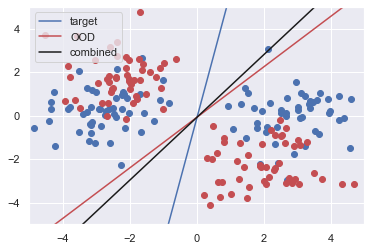

In [53]:
visualize_decision_boundary(100, 100, 45, alpha=0.8)

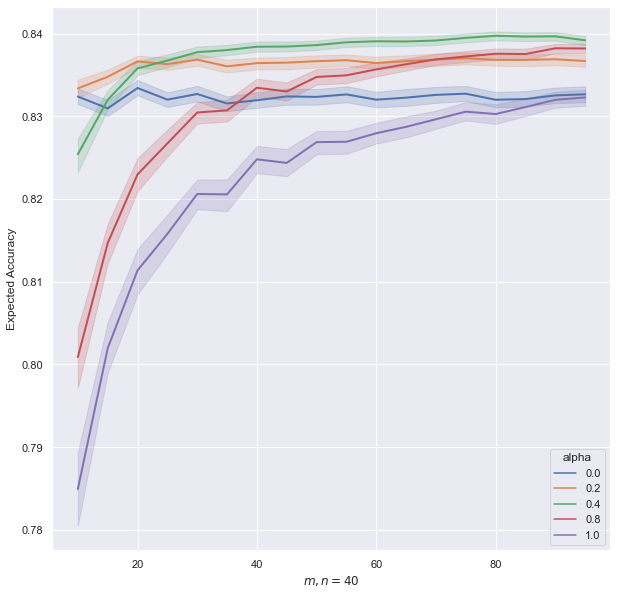

In [46]:
df = run_simulation(
    n = 40,
    n_test = 500,
    mu = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    theta = 20,
    alpha_range = [0.0, 0.2, 0.4, 0.8, 1.0],
    m_sizes = np.arange(10, 100, 5),
    reps = 1000,
)

### Theoretical Investigation

First we construct estimators for $\omega_t$ and $c_t$. We assume that class variances are known ($S_0 = S_1 = I$).

$$ \omega_t = (2I)^{-1}(\bar{X}_1 - \bar{X}_0) = \frac{1}{2}(\bar{X}_1 - \bar{X}_0) $$
$$ c_t = \omega^\top \bigg( \frac{\bar{X}_1 + \bar{X}_0}{2} \bigg) $$

Assuming equal class priors, we have $\bar{X}_1 \sim \mathcal{N}(\mu, 2I/n)$ and $\bar{X}_0 \sim \mathcal{N}(-\mu, 2I/n)$. Therefore, we get $\omega_t \sim \mathcal{N}(\mu, I/n)$ and $\frac{\bar{X}_1 + \bar{X}_0}{2} \sim \mathcal{N}(0, I/n)$.

We also notice that $\mathbb{E}[c | \omega_t] = \omega^\top 0 = 0$ and $V(c | \omega_t) = \omega^\top (I/n) \omega = \| \omega \|^2/n$. By laws of total expectation and variance, we can obtain $\mathbb{E}[c]=0$ and $V(c) = (\mu^2 + 2/n)/n$. Hence, we have $c \sim \mathcal{N}(0, (\mu^2 + 2/n)/n)$.

Let $\omega_t = [\omega_{t1}, \omega_{t2}]^\top$. Then we have the following disitributions pertaining to the target FLD parameters:

$$ \omega_{t1} \sim \mathcal{N}(\mu, 1/n)$$
$$ \omega_{t2} \sim \mathcal{N}(0, 1/n)$$
$$ c_t \sim \mathcal{N}(0, (\mu^2 + 2/n)/n)$$

Similarly, we can obtain the distributions pertaining to the OOD FLD parameters.

$$ \omega_{o1} \sim \mathcal{N}(\mu \cos \theta, 1/m)$$
$$ \omega_{o2} \sim \mathcal{N}(-\mu \sin \theta, 1/m)$$
$$ c_o \sim \mathcal{N}(0, (\mu^2 + 2/m)/m)$$

Since $\omega_h = \alpha \omega_{o} + (1-\alpha) \omega_{t}$ and $c_h = \alpha c_{o} + (1-\alpha) c_{t}$, 

$$ \omega_{h1} \sim \mathcal{N}(\alpha \cos \theta + (1-\alpha), \alpha^2/m + (1-\alpha)^2/n)$$
$$ \omega_{h2} \sim \mathcal{N}(-\alpha \sin \theta, \alpha^2/m + (1-\alpha)^2/n)$$
$$ c_h \sim \mathcal{N}(0, \alpha^2 (\mu^2 + 2/m)/m + (1-\alpha)^2 (\mu^2 + 2/n)/n )$$

The target risk of the combined decision rule is given by, 

$$ e_t(h) = \frac{1}{2} + \frac{1}{2} \mathbb{P}_{X \sim f_1} [\omega_h^\top X < c_h] -  \frac{1}{2} \mathbb{P}_{X \sim f_0} [\omega_h^\top X < c_h] $$

If $X \sim f_1 \equiv \mathcal{N}(\mu, I)$, then $\omega_h^\top X \sim \mathcal{N}(\omega_h^\top \mu, \| \omega_h \|^2)$ and If $X \sim f_0 \equiv \mathcal{N}(-\mu, I)$, then $\omega_h^\top X \sim \mathcal{N}(-\omega_h^\top \mu, \| \omega_h \|^2)$. Therefore, 

$$ e_t(h) = \frac{1}{2} + \frac{1}{2} \Phi \bigg( \frac{c_h - \omega_h^\top \mu}{\| \omega_h \|} \bigg) -  \frac{1}{2} \Phi \bigg( \frac{c_h + \omega_h^\top \mu}{\| \omega_h \|} \bigg)  $$

To numerically obtain $\mathbb{E}_{\omega_h \sim \Omega, c_h \sim C}[e_t(h)]$, we use a MC simulation technique. 

In [38]:
def expected_risk(w1, w2, c):
    risk = 0.5*(1 + norm.cdf((c-w1)/np.sqrt(w1**2 + w2**2)) - norm.cdf((c+w1)/np.sqrt(w1**2 + w2**2)))
    return risk

Text(0.5, 0, '$m, n=40$')

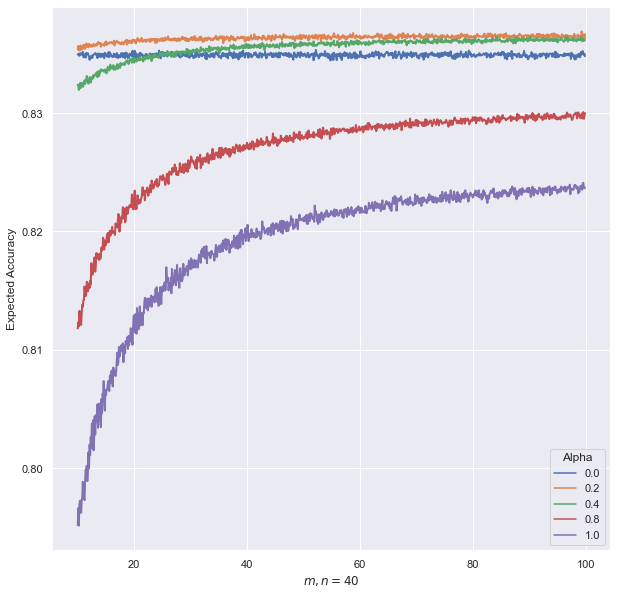

In [51]:
n = 40
m_sizes = np.arange(10, 100, 0.1)
theta = 20
alpha_range=[0.0, 0.2, 0.4, 0.8, 1.0]
reps = 2000

theta = np.radians(theta)
i = 0
df = pd.DataFrame()
for m in m_sizes:
    df.at[i, "m"] = m
    for alpha in alpha_range:
        mu_omega1 = alpha*np.cos(theta) + (1-alpha)
        sigma_omega1 = np.sqrt( (alpha**2/m + (1-alpha)**2/n))
        mu_omega2 = -alpha*np.sin(theta)
        sigma_omega2 = np.sqrt( (alpha**2/m + (1-alpha)**2/n))
        mu_c = 0
        sigma_c = np.sqrt( alpha**2/m*(1 + 2/m) + (1-alpha)**2/n*(1 + 2/n) )
        risk_rep = []
        for rep in range(reps):
            omega1 = np.random.normal(mu_omega1, sigma_omega1)
            omega2 = np.random.normal(mu_omega2, sigma_omega2)
            c = np.random.normal(mu_c, sigma_c)
            risk_rep.append(expected_risk(omega1, omega2, c))
        df.at[i, str(alpha)] = 1-np.mean(risk_rep)
    i+=1

dfm = df.melt(['m'], var_name='Alpha', value_name='Risk')
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Alpha", ax=ax, markers=True, ci=95, lw=2)
ax.set_ylabel("Expected Accuracy")
ax.set_xlabel(r"$m, n={}$".format(n))
# ax.set_xlim([0, 100])
